In [99]:
!pip install scikit-learn
!pip install miceforest
!pip install autoimpute

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import miceforest as mf
import math
from autoimpute.imputations import MultipleImputer
from sklearn.preprocessing import StandardScaler


In [100]:
!pip install miceforest --no-cache-dir
!pip install autoimpute



In [101]:
dataframe = pd.read_csv("Myocardial infarction complications Database.csv", header=0, na_values='?')


In [102]:
columns_to_drop = list(range(92, 95)) + [99, 100, 101, 102, 103,104] + list(range(112, 120)) + list(range(121, 124))


In [103]:
dataframe = dataframe.drop(dataframe.columns[columns_to_drop], axis=1)


In [104]:
print(dataframe.shape)


(1700, 104)


In [105]:
# Calculate the total number of missing values for each column
missing_values_count = dataframe.isnull().sum()

# Calculate the percentage of missing values for each column
missing_values_percentage = (missing_values_count / len(dataframe)) * 100

# Create a DataFrame to display the results
missing_values_df = pd.DataFrame({
    'Column': dataframe.columns,
    'Missing Values': missing_values_count,
    'Percentage': missing_values_percentage
})

# Sort the DataFrame by percentage of missing values in descending order
missing_values_df = missing_values_df.sort_values(by='Percentage', ascending=False)

# Adjust pandas settings to display all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the columns with their missing values percentage
print(missing_values_df)

                      Column  Missing Values  Percentage
KFK_BLOOD          KFK_BLOOD            1696   99.764706
IBS_NASL            IBS_NASL            1628   95.764706
D_AD_KBRIG        D_AD_KBRIG            1076   63.294118
S_AD_KBRIG        S_AD_KBRIG            1076   63.294118
NOT_NA_KB          NOT_NA_KB             686   40.352941
LID_KB                LID_KB             677   39.823529
NA_KB                  NA_KB             657   38.647059
GIPER_NA            GIPER_NA             375   22.058824
NA_BLOOD            NA_BLOOD             375   22.058824
K_BLOOD              K_BLOOD             371   21.823529
GIPO_K                GIPO_K             369   21.705882
AST_BLOOD          AST_BLOOD             285   16.764706
ALT_BLOOD          ALT_BLOOD             284   16.705882
D_AD_ORIT          D_AD_ORIT             267   15.705882
S_AD_ORIT          S_AD_ORIT             267   15.705882
DLIT_AG              DLIT_AG             248   14.588235
ROE                      ROE   

In [106]:
columns_to_drop = missing_values_percentage[missing_values_percentage > 90].index
dataframe=dataframe.drop(columns=columns_to_drop)


In [107]:
columns_to_fill = missing_values_percentage[missing_values_percentage < 10].index

for column in columns_to_fill:
    if dataframe[column].nunique() <= 8:  # Check if the column is binary
        mode_value = dataframe[column].mode()[0]
        dataframe[column] = dataframe[column].fillna(mode_value)
    else:# Check if the column is numerical
        median_value = dataframe[column].median()
        dataframe[column] = dataframe[column].fillna(median_value)


In [108]:
dataframe.drop(columns=['ID'], inplace=True)


In [109]:
target = dataframe['ZSN']
dataframe.drop(columns=['ZSN'], inplace=True)


In [110]:
numerical_df = pd.DataFrame()
binary_df = pd.DataFrame()

# Iterate over columns and categorize them
for column in dataframe.columns:
    if dataframe[column].nunique() <= 8:
        binary_df[column] = dataframe[column]
    else:
        numerical_df[column] = dataframe[column]

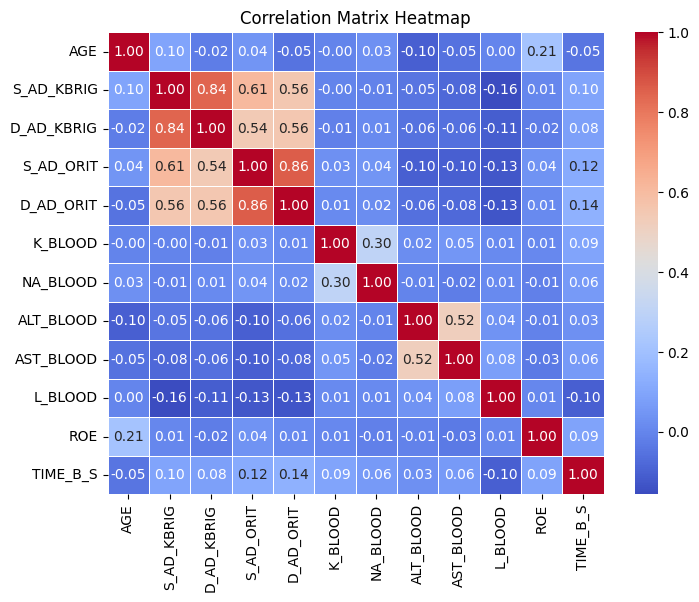

In [111]:
corr = numerical_df.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [112]:
columns_to_extract = ['S_AD_KBRIG', 'D_AD_KBRIG', 'S_AD_ORIT', 'D_AD_ORIT']
extracted_df = numerical_df[columns_to_extract]

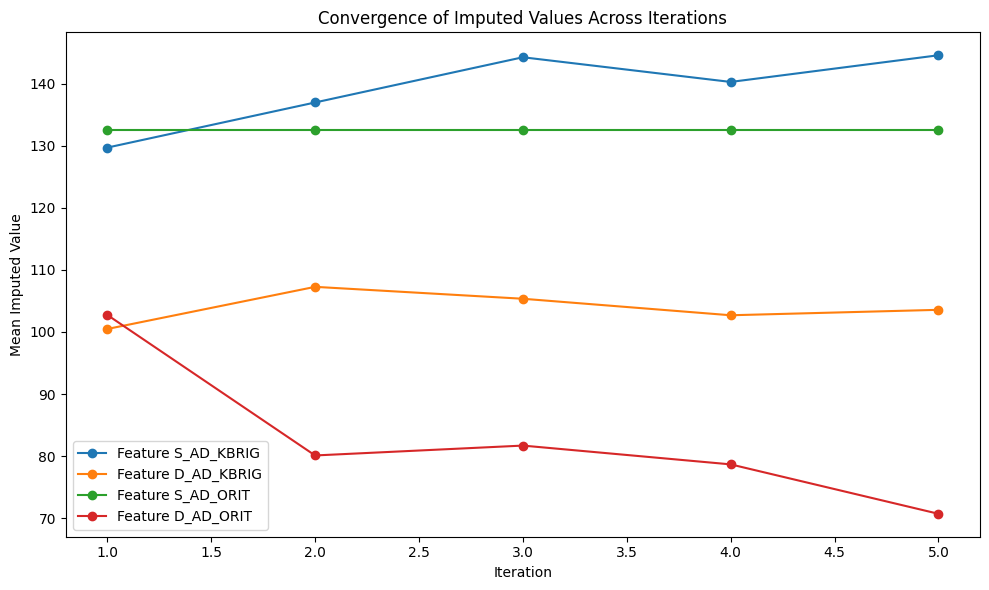

In [113]:
imputer = IterativeImputer(random_state=100, max_iter=5)

# Transform the data and track the changes
imputed_data = []
for i in range(1, imputer.max_iter + 1):
    imputer = IterativeImputer(random_state=100, max_iter=i, sample_posterior=True)
    imputed_data.append(imputer.fit_transform(extracted_df))

# Convert the list to an array for easier manipulation
imputed_data = np.array(imputed_data)

# Calculate mean imputed values for each feature at each iteration
mean_imputed_values = np.nanmean(imputed_data, axis=2)

# Plot the convergence of the mean imputed values
plt.figure(figsize=(10, 6))

for feature_idx in range(extracted_df.shape[1]):
    plt.plot(range(1, imputer.max_iter + 1),
             mean_imputed_values[:, feature_idx],
             marker='o', label=f'Feature {extracted_df.columns[feature_idx]}')
    plt.title('Convergence of Imputed Values Across Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Imputed Value')
    plt.legend()

plt.tight_layout()
plt.show()

In [114]:
column_3_iteration_5 = imputed_data[4, :, 2]


In [115]:
numerical_df['S_AD_ORIT'] = column_3_iteration_5


In [116]:
combined_df = pd.concat([binary_df, numerical_df], axis=1)


In [117]:
# Check if the DataFrames are defined
if 'binary_df' not in locals():
    raise NameError("binary_df is not defined.")
if 'numerical_df' not in locals():
    raise NameError("numerical_df is not defined.")

# Concatenate the two DataFrames horizontally (along columns)
try:
    combined_df = pd.concat([binary_df, numerical_df], axis=1)
    print("Combined DataFrame:")
    print(combined_df)
except Exception as e:
    raise ValueError(f"Error concatenating DataFrames: {e}")

# Create an ImputationKernel
try:
    kernel = mf.ImputationKernel(
        combined_df,
        datasets=5,
        save_all_iterations=True
    )
    print("ImputationKernel created successfully.")
except Exception as e:
    raise ValueError(f"Error creating ImputationKernel: {e}")

# Run the MICE algorithm for 5 iterations on each of the datasets
try:
    kernel.mice(5)
    print("MICE algorithm ran successfully.")
except Exception as e:
    raise ValueError(f"Error running MICE algorithm: {e}")

# Get the first imputed dataset
try:
    combined_df_kernel = kernel.complete_data(0)
    print("First imputed dataset:")
    print(combined_df_kernel.head())
except Exception as e:
    raise ValueError(f"Error retrieving imputed dataset: {e}")

# Verify that combined_df_kernel is now defined
if 'combined_df_kernel' not in locals():
    raise NameError("combined_df_kernel is still not defined.")
else:
    print("combined_df_kernel has been successfully defined.")


Streaming output truncated to the last 5000 lines.
219          1.0        1.0      1.0       0.0        0.0  51.0       160.0   
220          0.0        1.0      1.0       0.0        0.0  35.0       130.0   
221          0.0        1.0      1.0       0.0        0.0  65.0         NaN   
222          1.0        1.0      1.0       0.0        0.0  67.0         NaN   
223          1.0        1.0      1.0       0.0        0.0  63.0         NaN   
224          0.0        1.0      0.0       0.0        1.0  44.0         NaN   
225          1.0        0.0      1.0       0.0        0.0  53.0         NaN   
226          1.0        1.0      1.0       0.0        0.0  62.0       210.0   
227          0.0        1.0      1.0       0.0        0.0  57.0         NaN   
228          1.0        1.0      1.0       0.0        1.0  66.0       190.0   
229          1.0        1.0      1.0       0.0        0.0  51.0       110.0   
230          0.0        1.0      1.0       0.0        0.0  53.0       160.0   
2

In [118]:
combined_df_kernal = kernel.complete_data(0) # get the first imputed dataset

# the dataset now has no missing values
print("Total percent of missing values:", combined_df_kernal.isnull().sum().sum()/len(combined_df_kernal))

Total percent of missing values: 0.0


In [119]:
columns_with_missing_values = combined_df.columns[combined_df.isna().any()].tolist()


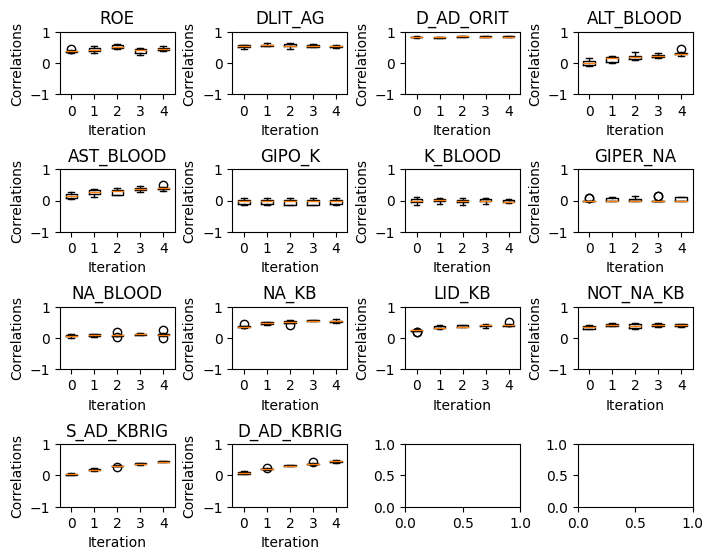

In [120]:
kernel.plot_correlations(variables=columns_with_missing_values, left=0.001, right=0.99, bottom = 0.001, top = 0.99, wspace=0.5, hspace=1.2)


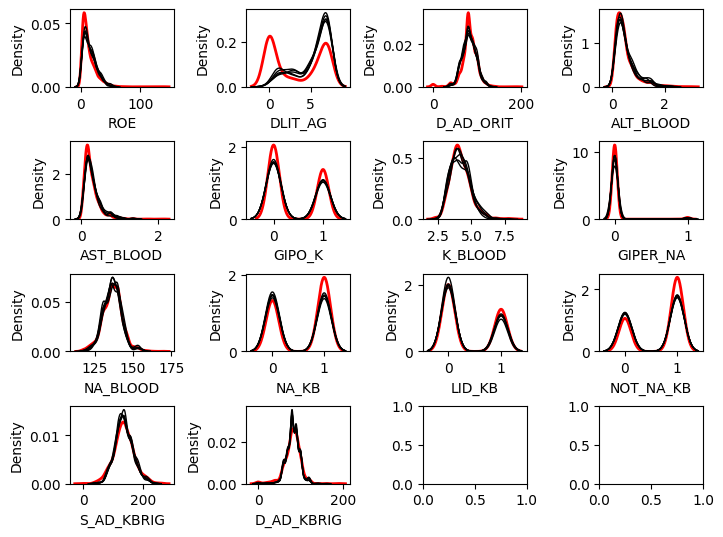

In [121]:
kernel.plot_imputed_distributions(variables=columns_with_missing_values, left=0.001, right=0.99, bottom = 0.001, top = 0.99, wspace=0.7, hspace=0.7)


In [122]:
combined_df_kernel = combined_df_kernel.drop(columns=["DLIT_AG"])
df_clean = combined_df_kernal.copy()


In [123]:
#Since we want to do some feauture engineering, we want all our columns to be on the same scale
scaler = StandardScaler()
combined_df_kernel[numerical_df.columns] = scaler.fit_transform(combined_df_kernel[numerical_df.columns])


In [124]:
print(df_clean.shape)
print(target.shape)

(1700, 100)
(1700,)


MODELS USING IMPUTED DATA

In [125]:
#Create feature and target dataset and do a train/test split
from sklearn.model_selection import train_test_split


X = df_clean
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

X_train_og, X_test_og, y_train_og, y_test_og = X_train, X_test, y_train, y_test

Selected feature indices: [98  8]
Accuracy with top 2 features: 0.7950089126559715
Selected feature indices: [95 91 98  8]
Accuracy with top 4 features: 0.7415329768270945
Selected feature indices: [94 38 95 91 98  8]
Accuracy with top 6 features: 0.7023172905525846
Selected feature indices: [96 93 94 38 95 91 98  8]
Accuracy with top 8 features: 0.6720142602495544
Selected feature indices: [97 88 96 93 94 38 95 91 98  8]
Accuracy with top 10 features: 0.6506238859180036
Selected feature indices: [37 89 97 88 96 93 94 38 95 91 98  8]
Accuracy with top 12 features: 0.6809269162210339
Selected feature indices: [99  5 37 89 97 88 96 93 94 38 95 91 98  8]
Accuracy with top 14 features: 0.6987522281639929
Selected feature indices: [87 40 99  5 37 89 97 88 96 93 94 38 95 91 98  8]
Accuracy with top 16 features: 0.6898395721925134
Selected feature indices: [23 26 87 40 99  5 37 89 97 88 96 93 94 38 95 91 98  8]
Accuracy with top 18 features: 0.7023172905525846
Selected feature indices: [ 2  1

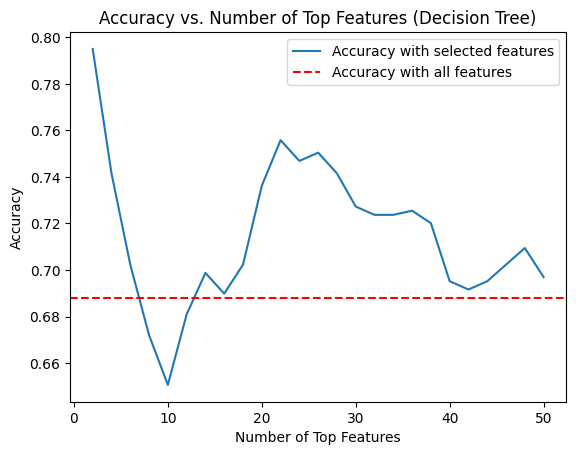

Selected feature column names:
Index(['ZSN_A', 'ROE'], dtype='object')
Best model accuracy: 0.7950089126559715
Best model: DecisionTreeClassifier(random_state=42)


In [126]:
#Using DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Initialize the DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

y_pred_dt = dtc.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
# Get feature importances
feature_importances = dtc.feature_importances_

# Define the range of number of top features to evaluate
num_features_list_dtc = list(range(2, X_train.shape[1] // 2 + 1, 2))
accuracies = []

best_accuracy_dtc = 0
best_model_dtc = None
best_selected_features_dtc = None

for num_features in num_features_list_dtc:
    # Select the top 'num_features' important features
    important_indices = np.argsort(feature_importances)[-num_features:]
    print(f"Selected feature indices: {important_indices}")

    # Create new datasets with only the selected features
    if isinstance(X_train, pd.DataFrame):
        X_train_selected = X_train.iloc[:, important_indices]
        X_test_selected = X_test.iloc[:, important_indices]
        selected_feature_names = X_train.columns[important_indices[::-1]]
    else:
        X_train_selected = X_train[:, important_indices]
        X_test_selected = X_test[:, important_indices]
        selected_feature_names = None

    # Train the model on the reduced dataset
    dtc_selected = DecisionTreeClassifier(random_state=42)
    dtc_selected.fit(X_train_selected, y_train)

    # Predict and evaluate with selected features
    y_pred_selected = dtc_selected.predict(X_test_selected)
    y_pred_proba_dtc = dtc_selected.predict_proba(X_test_selected)[:, 1]
    accuracy_selected = accuracy_score(y_test, y_pred_selected)
    accuracies.append(accuracy_selected)
    print(f"Accuracy with top {num_features} features: {accuracy_selected}")

    # Update the best model and selected features if accuracy improves
    if accuracy_selected > best_accuracy_dtc:
        best_accuracy_dtc = accuracy_selected
        best_model_dtc = dtc_selected
        best_selected_features_dtc = selected_feature_names
        best_proba_dtc = y_pred_proba_dtc

# Compute initial accuracy with all features
y_pred_full_dtc = dtc.predict(X_test)
accuracy_full_dtc = accuracy_score(y_test, y_pred_full_dtc)

# Plot the accuracies
plt.plot(num_features_list_dtc, accuracies, label='Accuracy with selected features')
plt.axhline(y=accuracy_full_dtc, color='r', linestyle='--', label='Accuracy with all features')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features (Decision Tree)')
plt.legend()
plt.show()

# Print the column names of the selected features
if best_selected_features_dtc is not None:
    print("Selected feature column names:")
    print(best_selected_features_dtc)

# Access the best model with highest accuracy
print("Best model accuracy:", best_accuracy_dtc)
print("Best model:", best_model_dtc)

Selected feature indices: [97  8]
Accuracy with top 2 features: 0.7985739750445633
Selected feature indices: [93 88 97  8]
Accuracy with top 4 features: 0.7878787878787878
Selected feature indices: [94 98 93 88 97  8]
Accuracy with top 6 features: 0.8181818181818182
Selected feature indices: [95 91 94 98 93 88 97  8]
Accuracy with top 8 features: 0.8057040998217468
Selected feature indices: [89 96 95 91 94 98 93 88 97  8]
Accuracy with top 10 features: 0.8181818181818182
Selected feature indices: [92 99 89 96 95 91 94 98 93 88 97  8]
Accuracy with top 12 features: 0.8057040998217468
Selected feature indices: [ 2 90 92 99 89 96 95 91 94 98 93 88 97  8]
Accuracy with top 14 features: 0.8057040998217468
Selected feature indices: [ 7 38  2 90 92 99 89 96 95 91 94 98 93 88 97  8]
Accuracy with top 16 features: 0.8057040998217468
Selected feature indices: [37 39  7 38  2 90 92 99 89 96 95 91 94 98 93 88 97  8]
Accuracy with top 18 features: 0.8074866310160428
Selected feature indices: [ 4  1

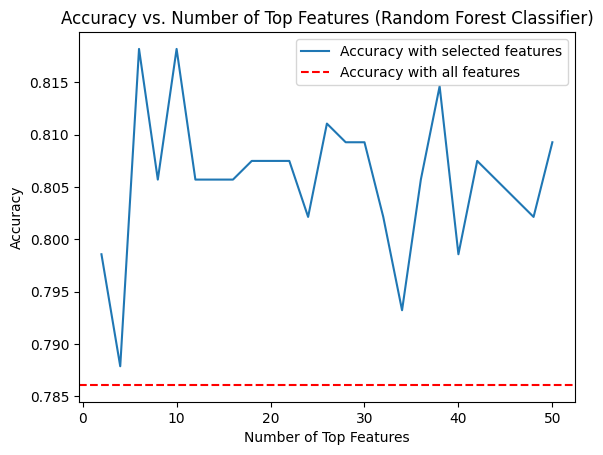

Selected feature column names:
Index(['ZSN_A', 'L_BLOOD', 'AGE', 'K_BLOOD', 'ROE', 'NA_BLOOD'], dtype='object')
Best model accuracy: 0.8181818181818182
Best model: RandomForestClassifier(random_state=42)


In [127]:
#Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train a random forest classifier and get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# Get feature importances
feature_importances = rf.feature_importances_

# Iterate over different numbers of top features and evaluate the model
num_features_list = list(range(2, X_train.shape[1] // 2 + 1, 2))
accuracies = []

best_accuracy = 0
best_model = None
best_selected_features = None

for num_features in num_features_list:
    # Select the top 'num_features' important features
    important_indices = np.argsort(feature_importances)[-num_features:]
    print(f"Selected feature indices: {important_indices}")

    # Create new datasets with only the selected features
    if isinstance(X_train, pd.DataFrame):
        X_train_selected = X_train.iloc[:, important_indices]
        X_test_selected = X_test.iloc[:, important_indices]
        selected_feature_names = X_train.columns[important_indices[::-1]]
    else:
        X_train_selected = X_train[:, important_indices]
        X_test_selected = X_test[:, important_indices]
        selected_feature_names = None

    # Train the model on the reduced dataset
    rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_selected.fit(X_train_selected, y_train)

    # Predict and evaluate with selected features
    y_pred_selected = rf_selected.predict(X_test_selected)
    accuracy_selected = accuracy_score(y_test, y_pred_selected)
    y_pred_proba = rf_selected.predict_proba(X_test_selected)[:, 1]
    accuracies.append(accuracy_selected)
    print(f"Accuracy with top {num_features} features: {accuracy_selected}")

    # Update the best model and selected features if accuracy improves
    if accuracy_selected > best_accuracy:
        best_accuracy = accuracy_selected
        best_model = rf_selected
        best_selected_features = selected_feature_names
        best_proba = y_pred_proba

# Compute initial accuracy with all features
y_pred_full = rf.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred_full)

# Plot the accuracies
plt.plot(num_features_list, accuracies, label='Accuracy with selected features')
plt.axhline(y=accuracy_full, color='r', linestyle='--', label='Accuracy with all features')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features (Random Forest Classifier)')
plt.legend()
plt.show()

# Print the column names of the selected features
if best_selected_features is not None:
    print("Selected feature column names:")
    print(best_selected_features)

# Access the best model with highest accuracy
print("Best model accuracy:", best_accuracy)
print("Best model:", best_model)

Selected feature indices: [52  8]
Accuracy with top 2 features: 0.82174688057041
Selected feature indices: [26 33 52  8]
Accuracy with top 4 features: 0.8235294117647058
Selected feature indices: [31 23 26 33 52  8]
Accuracy with top 6 features: 0.82174688057041
Selected feature indices: [78  6 31 23 26 33 52  8]
Accuracy with top 8 features: 0.8128342245989305
Selected feature indices: [38 83 78  6 31 23 26 33 52  8]
Accuracy with top 10 features: 0.8057040998217468
Selected feature indices: [87 84 38 83 78  6 31 23 26 33 52  8]
Accuracy with top 12 features: 0.7700534759358288
Selected feature indices: [27 32 87 84 38 83 78  6 31 23 26 33 52  8]
Accuracy with top 14 features: 0.7754010695187166
Selected feature indices: [ 0 40 27 32 87 84 38 83 78  6 31 23 26 33 52  8]
Accuracy with top 16 features: 0.7629233511586453
Selected feature indices: [88  4  0 40 27 32 87 84 38 83 78  6 31 23 26 33 52  8]
Accuracy with top 18 features: 0.7700534759358288
Selected feature indices: [43 37 88 

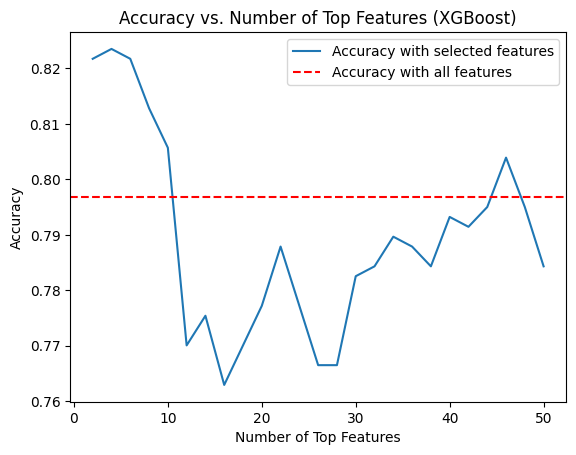

Selected feature column names:
Index(['ZSN_A', 'n_r_ecg_p_05', 'MP_TP_POST', 'zab_leg_01'], dtype='object')
Best model accuracy: 0.8235294117647058
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [128]:
#Using XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

xgb = XGBClassifier(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
# Get feature importances
feature_importances = xgb.feature_importances_

num_features_list_xgb = list(range(2, X_train.shape[1] // 2 + 1, 2))
accuracies = []

best_accuracy_xgb = 0
best_model_xgb = None
best_selected_features_xgb = None

for num_features in num_features_list_xgb:
    # Select the top 'num_features' important features
    important_indices = np.argsort(feature_importances)[-num_features:]
    print(f"Selected feature indices: {important_indices}")

    # Create new datasets with only the selected features
    if isinstance(X_train, pd.DataFrame):
        X_train_selected = X_train.iloc[:, important_indices]
        X_test_selected = X_test.iloc[:, important_indices]
        selected_feature_names = X_train.columns[important_indices[::-1]]
    else:
        X_train_selected = X_train[:, important_indices]
        X_test_selected = X_test[:, important_indices]
        selected_feature_names = None

    # Train the model on the reduced dataset
    xgb_selected = XGBClassifier(n_estimators=100, random_state=42)
    xgb_selected.fit(X_train_selected, y_train)

    # Predict and evaluate with selected features
    y_pred_selected = xgb_selected.predict(X_test_selected)
    accuracy_selected = accuracy_score(y_test, y_pred_selected)
    y_pred_proba_xgb = xgb_selected.predict_proba(X_test_selected)[:, 1]
    accuracies.append(accuracy_selected)
    print(f"Accuracy with top {num_features} features: {accuracy_selected}")

    # Update the best model and selected features if accuracy improves
    if accuracy_selected > best_accuracy_xgb:
        best_accuracy_xgb = accuracy_selected
        best_model_xgb = xgb_selected
        best_selected_features_xgb = selected_feature_names
        best_proba_xgb = y_pred_proba_xgb


# Compute initial accuracy with all features
y_pred_full_xgb = xgb.predict(X_test)
accuracy_full_xgb = accuracy_score(y_test, y_pred_full_xgb)

# Plot the accuracies
plt.plot(num_features_list_xgb, accuracies, label='Accuracy with selected features')
plt.axhline(y=accuracy_full_xgb, color='r', linestyle='--', label='Accuracy with all features')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features (XGBoost)')
plt.legend()
plt.show()

# Print the column names of the selected features
if best_selected_features_xgb is not None:
    print("Selected feature column names:")
    print(best_selected_features_xgb)

# Access the best model with highest accuracy
print("Best model accuracy:", best_accuracy_xgb)
print("Best model:", best_model_xgb)

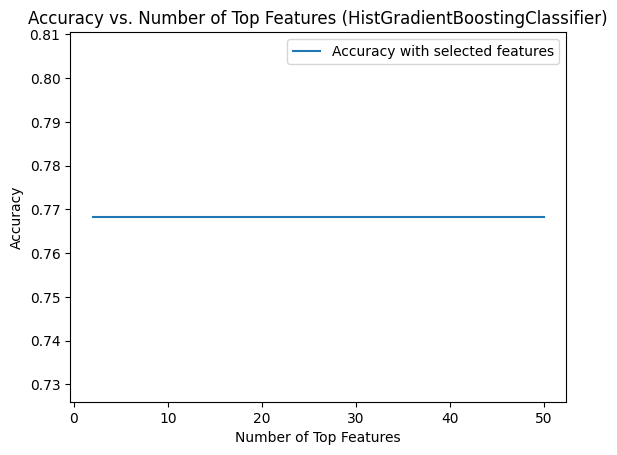

Selected feature column names:
8     DLIT_AG
5    IBS_POST
Name: Feature, dtype: object
Best model accuracy: 0.768270944741533
Best model: HistGradientBoostingClassifier(learning_rate=0.01, random_state=42)


In [129]:
#Using HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, and y_test are already defined

# Initialize the classifier
hgbc = HistGradientBoostingClassifier(max_depth=None, learning_rate=0.01, max_iter=100, random_state=42)

# Train the classifier
hgbc.fit(X_train, y_train)

# Define a function to perform feature selection and evaluate performance
def evaluate_feature_selection(X_train, X_test, y_train, y_test, model, feature_importances, num_features_list):
    accuracies = []
    best_accuracy = 0
    best_model = None
    best_selected_features = None

    for num_features in num_features_list:
        # Select the top 'num_features' important features
        top_features = feature_importances.iloc[:num_features]['Feature']
        important_indices = [X.columns.get_loc(f) for f in top_features]

        # Create new datasets with only the selected features
        X_train_selected = X_train.iloc[:, important_indices]
        X_test_selected = X_test.iloc[:, important_indices]

        # Train the model on the reduced dataset
        model.fit(X_train_selected, y_train)

        # Predict and evaluate with selected features
        y_pred_selected = model.predict(X_test_selected)
        accuracy_selected = accuracy_score(y_test, y_pred_selected)
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]
        accuracies.append(accuracy_selected)

        # Update the best model and selected features if accuracy improves
        if accuracy_selected > best_accuracy:
            best_accuracy = accuracy_selected
            best_model = model
            best_selected_features = top_features
            best_proba = y_pred_proba

    return accuracies, best_model, best_selected_features, best_proba

# Compute permutation feature importances
result = permutation_importance(hgbc, X_train, y_train, n_repeats=10, random_state=42)
importances = result.importances_mean

# Create a DataFrame with feature names and importances
importance_df = pd.DataFrame({
    'Feature': dataframe.columns,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Define the number of top features to try
num_features_list_hgbc = list(range(2, X_train.shape[1] // 2 + 1, 2))

# Evaluate feature selection and performance
accuracies_hgbc, best_model_hgbc, best_selected_features_hgbc, best_proba_hgbc = evaluate_feature_selection(
    X_train, X_test, y_train, y_test, hgbc, importance_df, num_features_list_hgbc
)

# Plot the accuracies
plt.plot(num_features_list_hgbc, accuracies_hgbc, label='Accuracy with selected features')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features (HistGradientBoostingClassifier)')
plt.legend()
plt.show()

# Print the column names of the selected features
if best_selected_features_hgbc is not None:
    print("Selected feature column names:")
    print(best_selected_features_hgbc)

# Access the best model with highest accuracy
print("Best model accuracy:", max(accuracies_hgbc))
print("Best model:", best_model_hgbc)


In [130]:
#To choose the "best" model, we compare the accuracies
acc_all = [best_accuracy, best_accuracy_xgb, best_accuracy_dtc, max(accuracies_hgbc)]
model_names = ["RandomForest", "XGBoost", "DecisionTree", "HistGradientBoostingClassifier"]

# Find the index of the highest accuracy
max_index = acc_all.index(max(acc_all))

# Get the name of the model with the highest accuracy
best_model_name = model_names[max_index]

print(f"The best model choice is: {best_model_name} with accuracy: {acc_all[max_index]}")


The best model choice is: XGBoost with accuracy: 0.8235294117647058


In [131]:
def avg_accuracy(model, selected_names, fea, tar):

  #Only keep best features
  X_best = fea.loc[:, selected_names]

  # Initialize a list to store accuracies
  accuracies_str = []

  # Train the classifier for 100 iterations
  for i in range(100):
      X_train, X_test, y_train, y_test = train_test_split(X_best, tar, test_size=0.2, stratify=target)

      # Train the classifier
      model.fit(X_train, y_train)

      # Make predictions
      y_pred = model.predict(X_test)

      # Calculate accuracy
      accuracy = accuracy_score(y_test, y_pred)

      # Append accuracy to the list
      accuracies_str.append(accuracy)

  # Calculate average accuracy
  average_accuracy = np.mean(accuracies_str)

  # Calculate standard deviation of accuracies
  std_deviation = np.std(accuracies_str)

  print("Model:", model)
  print("Average Accuracy:", average_accuracy)
  print("Standard Deviation of Accuracy:", std_deviation)

  import scipy.stats as stats

  standard_error = std_deviation / (len(accuracies) ** 0.5)

  # Calculate the z-value for a 99% confidence level (since we're using the normal distribution)
  z_value = stats.norm.ppf(0.995)

  # Calculate the margin of error
  margin_of_error = z_value * standard_error

  # Calculate the lower and upper bounds of the confidence interval
  lower_bound = average_accuracy - margin_of_error
  upper_bound = average_accuracy + margin_of_error

  print("99% Confidence Interval for Accuracy (using normal distribution):", (lower_bound, upper_bound))

  return average_accuracy

In [132]:
#Get average accuracy for DecisionTreeClassifier
accuracy_dtc = avg_accuracy(best_model_dtc, best_selected_features_dtc, X, y)

Model: DecisionTreeClassifier(random_state=42)
Average Accuracy: 0.7955
Standard Deviation of Accuracy: 0.01196487795584518
99% Confidence Interval for Accuracy (using normal distribution): (0.7893361033495895, 0.8016638966504105)


In [133]:
#Get average accuracy for RandomForestClassifier
accuracy_rf = avg_accuracy(best_model, best_selected_features, X, y)

Model: RandomForestClassifier(random_state=42)
Average Accuracy: 0.8022647058823531
Standard Deviation of Accuracy: 0.01306660472998055
99% Confidence Interval for Accuracy (using normal distribution): (0.7955332372100782, 0.808996174554628)


In [134]:
#Get average accuracy for XGBoost
accuracy_xgb = avg_accuracy(best_model_xgb, best_selected_features_xgb, X, y)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)
Average Accuracy: 0.8135294117647058
Standard Deviation of Accuracy: 0.012643638388355687
99% Confidence Interval for Accuracy (using normal distribution): (0.8070158409118654, 0.8200429826175463)


In [135]:
#Get average accuracy for HGBoostingC
accuracy_hgbc = avg_accuracy(best_model_hgbc, best_selected_features_hgbc, X, y)

Model: HistGradientBoostingClassifier(learning_rate=0.01, random_state=42)
Average Accuracy: 0.7676470588235295
Standard Deviation of Accuracy: 0.0
99% Confidence Interval for Accuracy (using normal distribution): (0.7676470588235295, 0.7676470588235295)


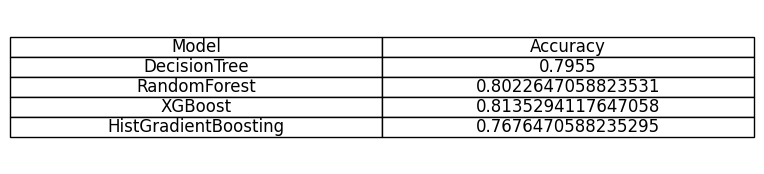

In [136]:
#For table creation


# Create a DataFrame with the accuracy values
accuracy_data = {
    'Model': ['DecisionTree', 'RandomForest', 'XGBoost', 'HistGradientBoosting'],
    'Accuracy': [accuracy_dtc, accuracy_rf, accuracy_xgb, accuracy_hgbc]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Plotting the table using matplotlib
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust size as needed

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table = ax.table(cellText=accuracy_df.values, colLabels=accuracy_df.columns, cellLoc='center', loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)  # Adjust scaling as needed


# Display the plot
plt.show()


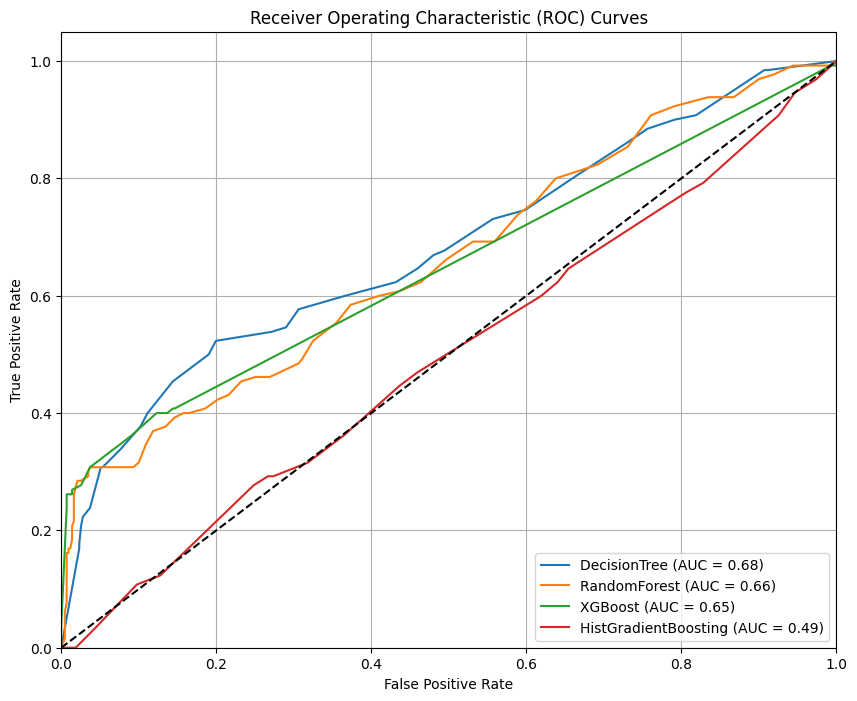

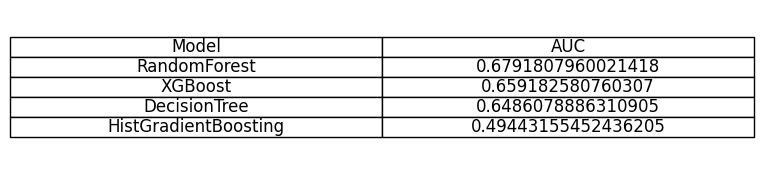

In [141]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Initialize lists to store AUC values and model names
auc_values = []
model_names = ['RandomForest', 'XGBoost', 'DecisionTree', 'HistGradientBoosting']

# Compute AUC and plot ROC curve for DecisionTree

fpr_dtc, tpr_dtc, _ = roc_curve(y_test, best_proba_dtc)
auc_dtc = roc_auc_score(y_test, best_proba_dtc)
auc_values.append(auc_dtc)

# Compute AUC and plot ROC curve for RandomForest

fpr_rf, tpr_rf, _ = roc_curve(y_test, best_proba)
auc_rf = roc_auc_score(y_test, best_proba)
auc_values.append(auc_rf)

# Compute AUC and plot ROC curve for XGBoost

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, best_proba_xgb)
auc_xgb = roc_auc_score(y_test, best_proba_xgb)
auc_values.append(auc_xgb)

# Compute AUC and plot ROC curve for HistGradientBoosting

fpr_hgbc, tpr_hgbc, _ = roc_curve(y_test, best_proba_hgbc)
auc_hgbc = roc_auc_score(y_test, best_proba_hgbc)
auc_values.append(auc_hgbc)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_dtc, tpr_dtc, label=f'DecisionTree (AUC = {auc_dtc:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_hgbc, tpr_hgbc, label=f'HistGradientBoosting (AUC = {auc_hgbc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Create a DataFrame for the AUC values
auc_df = pd.DataFrame({
    'Model': model_names,
    'AUC': auc_values
})


# Save the AUC values table as an image (optional)
fig, ax = plt.subplots(figsize=(8, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=auc_df.values, colLabels=auc_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()


MODELS WITH MISSING DATA

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 100}
Training accuracy with optimal hyperparameters: 0.9824407374890255
0.82174688057041
          Feature  Importance
9           ZSN_A    0.074451
43         lat_im    0.001054
86        L_BLOOD    0.000702
3       STENOK_AN    0.000615
47  ritm_ecg_p_01    0.000439
0             AGE    0.000000
72   n_p_ecg_p_12    0.000000
71   n_p_ecg_p_11    0.000000
70   n_p_ecg_p_10    0.000000
69   n_p_ecg_p_09    0.000000
68   n_p_ecg_p_08    0.000000
67   n_p_ecg_p_07    0.000000
66   n_p_ecg_p_06    0.000000
65   n_p_ecg_p_05    0.000000
64   n_p_ecg_p_04    0.000000
61   n_r_ecg_p_10    0.000000
63   n_p_ecg_p_03    0.000000
62   n_p_ecg_p_01    0.000000
74    fibr_ter_02    0.000000
60   n_r_ecg_p_09    0.000000
59   n_r_ecg_p_08    0.000000
58   n_r_ecg_p_06    0.000000
57   n_r_ecg_p_05    0.000000
56   n_r_ecg_p_04    0.000000
55   n_r_ecg_p_03    0.000000
54   n_r_ecg_p_02    0.000000
73    fibr_ter_01    0.0

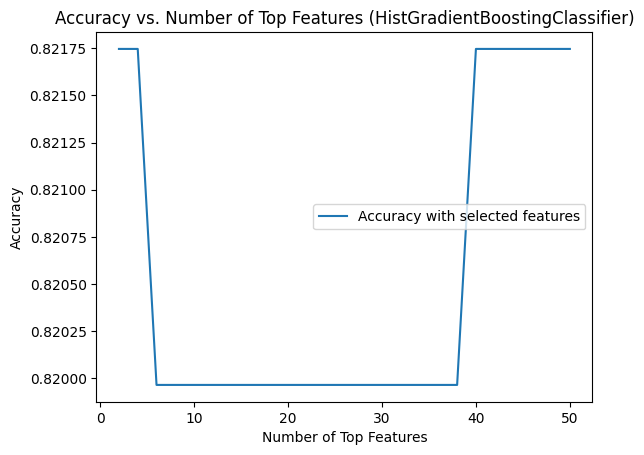

Selected feature column names:
9      ZSN_A
43    lat_im
Name: Feature, dtype: object
Best model accuracy: 0.82174688057041
Best model: HistGradientBoostingClassifier(learning_rate=0.01, max_depth=3)


In [42]:
#now using data with missing values
X = dataframe
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

param_grid = {
    'max_depth': [3, 5, 7, 10, None],  # Example values, adjust as needed
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Example values, adjust as needed
    'max_iter': [100, 200, 300, 400, 500]
}

# Initialize the classifier
hgbc_classifier = HistGradientBoostingClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(hgbc_classifier, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the classifier with the best parameters
best_hgbc_classifier = grid_search.best_estimator_

# Make predictions
y_pred = best_hgbc_classifier.predict(X_train)

# Calculate accuracy
accuracy_tr = accuracy_score(y_train, y_pred)
print("Training accuracy with optimal hyperparameters:", accuracy_tr)

model_m = HistGradientBoostingClassifier(max_depth= 3,learning_rate= 0.01,max_iter= 100)

# Train the classifier
model_m.fit(X_train, y_train)
y_pred_hgbc_m = model_m.predict(X_test)

accuracy_hgbc_m = accuracy_score(y_test, y_pred_hgbc_m)

print(accuracy_hgbc_m)


# Compute permutation feature importances
result = permutation_importance(model_m, X_train, y_train, n_repeats=10, random_state=42)
importances = result.importances_mean

# Create a DataFrame with feature names and importances
importance_df = pd.DataFrame({
    'Feature': dataframe.columns,
    'Importance': importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Define a function to perform feature selection and evaluate performance
def evaluate_feature_selection(X_train, X_test, y_train, y_test, model, feature_importances, num_features_list):
    accuracies = []
    best_accuracy = 0
    best_model = None
    best_selected_features = None

    for num_features in num_features_list:
        # Select the top 'num_features' important features
        top_features = feature_importances.iloc[:num_features]['Feature']
        important_indices = [X.columns.get_loc(f) for f in top_features]

        # Create new datasets with only the selected features
        X_train_selected = X_train.iloc[:, important_indices]
        X_test_selected = X_test.iloc[:, important_indices]

        # Train the model on the reduced dataset
        model.fit(X_train_selected, y_train)

        # Predict and evaluate with selected features
        y_pred_selected = model.predict(X_test_selected)
        accuracy_selected = accuracy_score(y_test, y_pred_selected)
        accuracies.append(accuracy_selected)

        # Update the best model and selected features if accuracy improves
        if accuracy_selected > best_accuracy:
            best_accuracy = accuracy_selected
            best_model = model
            best_selected_features = top_features

    return accuracies, best_model, best_selected_features


# Define the number of top features to try
num_features_list_hgbc = list(range(2, X_train.shape[1] // 2 + 1, 2))

# Evaluate feature selection and performance
accuracies_hgbc, best_model_hgbc, best_selected_features_hgbc = evaluate_feature_selection(
    X_train, X_test, y_train, y_test, model_m, importance_df, num_features_list_hgbc
)

# Plot the accuracies
plt.plot(num_features_list_hgbc, accuracies_hgbc, label='Accuracy with selected features')
plt.xlabel('Number of Top Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features (HistGradientBoostingClassifier)')
plt.legend()
plt.show()

# Print the column names of the selected features
if best_selected_features_hgbc is not None:
    print("Selected feature column names:")
    print(best_selected_features_hgbc)

# Access the best model with highest accuracy
print("Best model accuracy:", max(accuracies_hgbc))
print("Best model:", best_model_hgbc)